# EcoPoints Data Analysis

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [12]:
with open('data.json') as f:
    data = json.load(f)

In [15]:
df = pd.json_normalize(data)

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

In [34]:
df['Gps-Speed'] = pd.to_numeric(df['data.Gps-Speed'])
df['Vehicle Speed'] = pd.to_numeric(df['data.Vehicle Speed'])
df['Engine RPM_CLEANED_RES'] = pd.to_numeric(df['data.Engine RPM_CLEANED_RES'])
df['Engine Load'] = pd.to_numeric(df['data.Engine Load'])

In [35]:
plt.figure(figsize=(10, 12))

<Figure size 1000x1200 with 0 Axes>

<Figure size 1000x1200 with 0 Axes>

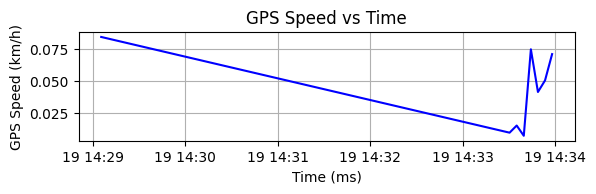

In [36]:
plt.subplot(3, 1, 1)
plt.plot(df['timestamp'], df['Gps-Speed'], label='GPS Speed', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('GPS Speed (km/h)')
plt.title('GPS Speed vs Time')
plt.grid(True)

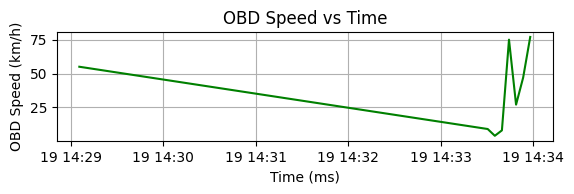

In [37]:
plt.subplot(3, 1, 2)
plt.plot(df['timestamp'], df['Vehicle Speed'], label='OBD Speed', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('OBD Speed (km/h)')
plt.title('OBD Speed vs Time')
plt.grid(True)

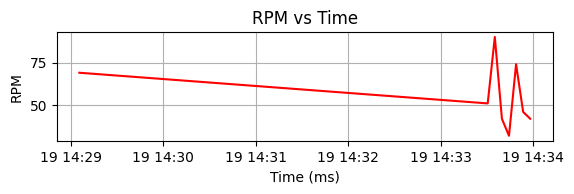

In [38]:
plt.subplot(3, 1, 3)
plt.plot(df['timestamp'], df['Engine RPM_CLEANED_RES'], label='RPM', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('RPM')
plt.title('RPM vs Time')
plt.grid(True)

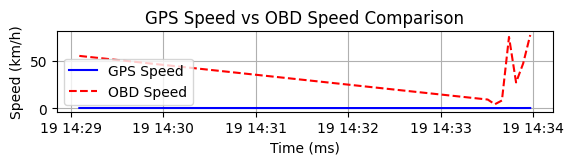

In [39]:
plt.subplot(4, 1, 4)
plt.plot(df['timestamp'], df['Gps-Speed'], label='GPS Speed', color='blue')
plt.plot(df['timestamp'], df['Vehicle Speed'], label='OBD Speed', color='red', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Speed (km/h)')
plt.title('GPS Speed vs OBD Speed Comparison')
plt.legend()
plt.grid(True)

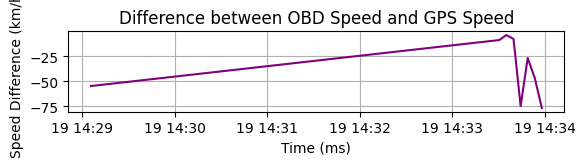

In [40]:
df['speed_difference'] = df['Gps-Speed'] - df['Vehicle Speed']

plt.subplot(4, 1, 4)
plt.plot(df['timestamp'], df['speed_difference'], label='Difference (OBD - GPS)', color='purple')
plt.xlabel('Time (ms)')
plt.ylabel('Speed Difference (km/h)')
plt.title('Difference between OBD Speed and GPS Speed')
plt.grid(True)

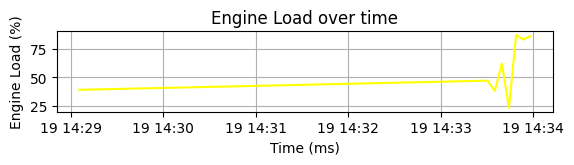

In [41]:
plt.subplot(4, 1, 4)
plt.plot(df['timestamp'], df['Engine Load'], label='Engine Load', color='yellow')
plt.xlabel('Time (ms)')
plt.ylabel('Engine Load (%)')
plt.title('Engine Load over time')
plt.grid(True)